# edu-cater 

In [1]:
# imports

from selenium import webdriver
from bs4 import BeautifulSoup
import requests
import os
import json
import csv

from collections import Counter
import operator

import pandas as pd
import numpy as np
import pickle
import time
import seaborn as sns
from scipy.io import savemat, loadmat
from matplotlib import pyplot as plt
%matplotlib inline

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

from sklearn.feature_extraction.text import TfidfVectorizer # ???

import gensim
from gensim.utils import simple_preprocess
from gensim.models import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.matutils import jaccard
from gensim.matutils import jensen_shannon

from sklearn.metrics.pairwise import cosine_similarity as cos_sim

import pyLDAvis
from pyLDAvis import gensim as pyldagensim

import networkx as nx
from networkx.algorithms import shortest_path


# import edu-cater classes/functions
from edutools import course_scraper

[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


In [2]:
# pipeline
run_pipeline = 0
scraper = course_scraper() 

if run_pipeline == 1:
    scraper.scrape_urls()  
    scraper.scrape_courses()
    scraper.scrape_course_network()

In [3]:
scraper.load_urls()
scraper.urls_all[0]

'https://www.coursera.org/learn/ai-for-everyone'

# Latent Dirichlet Allocation (LDA)

In [4]:
# define preprocessing functions: tokenization, stemming, lemmatization 
# based off of code from https://github.com/priya-dwivedi/Deep-Learning/blob/master/topic_modeling/LDA_Newsgroup.ipynb

stopwords = list(gensim.parsing.preprocessing.STOPWORDS)
stopwords.extend(['youâ', 'week', 'write', 'solv', 'peer', 'assign', 'beginn',
                  'need', 'peopl', 'content', 'teach', 'assess', 'plan', 'capston',
                  'video', 'lesson', 'think', 'idea', 'lectur', 'learner'])

def lemmatize_stemming(text):
    stemmer = SnowballStemmer("english")
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    stem_dict = []
    for token in gensim.utils.simple_preprocess(text) :
        if token not in stopwords and lemmatize_stemming(token) not in stopwords and len(token) > 3:
            result.append(lemmatize_stemming(token))
            stem_dict.append((lemmatize_stemming(token), token))
            
    return result, stem_dict

In [34]:
# aggregate all text info (description, syllabus) and preprocess

# remove courses that aren't in English (even though they had an English tag!)
all_courses = np.arange(2635)
bad_courses = np.array([661, 710, 919, 925, 949, 1701, 1714, 1717, 1723, 2398, 2612])
good_courses = np.setdiff1d(all_courses, bad_courses)

processed_info = []
nreviews = []
stars = []
hours = []
levels = []
enrollment = []
course_info_all = []
titles_all = []
skills_all = []
dict_stem_full = []

for i in range(len(good_courses)): #fixthis
    if i%500 == 0:
        print(i)
    with open('course_info_short/course' + str(good_courses[i]) + '.json') as json_file:
        course_info = json.load(json_file)
    allinfo = course_info['title'] + ' ' + course_info['description'] \
            + ' ' + course_info['syllabus_headings'] + ' ' + course_info['syllabus_descriptions'] 
    tmpskills = ''
    for skill in course_info['skills']:
        allinfo = allinfo # +  ' ' + skill
        tmpskills = tmpskills + ' ' + skill
    for occupation in course_info['occupations']:
        allinfo = allinfo # + ' ' + occupation
    for review in course_info['reviews']:
        allinfo = allinfo  # + ' ' + review
    nreviews.append(course_info['nreviews'])
    stars.append(course_info['stars'])
    hours.append(course_info['hours'])
    levels.append(course_info['level'])
    enrollment.append(course_info['enrollment'])
    titles_all.append(course_info['title'])
    
    allinfo.replace('[^A-Za-z0-9]+', ' ')
    tmpskills.replace('[^A-Za-z0-9]+', ' ')
   
    preprocessed, stemdict = preprocess(allinfo)
    processed_info.append(preprocessed)
    skills_all.append(preprocess(tmpskills))
    course_info_all.append(allinfo)
    dict_stem_full.extend(stemdict)
    
# save course titles for web app
file = open('edu-app/course_titles.pkl', 'wb')
pickle.dump(titles_all, file)
file.close()

# save numeric info
stars = np.array(stars)
hours = np.array(hours)
enrollment = np.array(enrollment)
savemat('edu-app/course_numeric_info.mat', {'stars': stars, 'hours': hours, 'enrollment': enrollment})


0
500
1000
1500
2000
2500


In [6]:
# make a dictionary with a) stemmed word and 
# b) lemmatized version of word most often associated with stemmed word

dict_stem_allfull = {}
for i in range(len(dict_stem_full)):
    if dict_stem_full[i][0] not in dict_stem_allfull.keys():
        dict_stem_allfull[dict_stem_full[i][0]] = []
    dict_stem_allfull[dict_stem_full[i][0]].append(dict_stem_full[i][1])
    
stemmed_words = list(dict_stem_allfull.keys())

dict_stem_maxword = {}
for stemmed in stemmed_words:
    word_counts = dict(Counter(dict_stem_allfull[stemmed]))
    maxword = max(word_counts.items(), key=operator.itemgetter(1))[0]
    dict_stem_maxword[stemmed] = WordNetLemmatizer().lemmatize(maxword, pos='v')
        

In [ ]:
# EDA for quantitative info

fig = plt.figure(figsize=(15,4))

fig.add_subplot(131)
plt.hist((np.array(stars)),20); plt.title('Rating')
fig.add_subplot(132)
plt.hist((hours),20); plt.title('Length (hours)')
fig.add_subplot(133)
plt.hist(np.log10(enrollment),20); plt.title('Enrollment (log10)')
plt.savefig('course_numeric_info.png')
plt.show()

In [7]:
# make dictionary
dictionary = gensim.corpora.Dictionary(processed_info)
print('Length of original dictionary:', len(dictionary))

# remove rare and common words
dictionary.filter_extremes(no_below=10, no_above=.25, keep_n=100000)
print('Length of filtered dictionary:', len(dictionary))

# make bag of words
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_info]

Length of original dictionary: 18839
Length of filtered dictionary: 3076


In [11]:
# run LDA model for different # of topics and calculate coherence

ntopics_list = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
ntopics_list = [50, 100, 150, 200]
myseed = 0

coherence_all_cv = []
coherence_all_umass = []
perplexity_all = []
jsdists_all = []

for ntopics in ntopics_list:
    print(ntopics)
    lda_model =  LdaMulticore(bow_corpus, num_topics = ntopics, id2word = dictionary,
                              random_state = myseed, passes = 10, workers = 2, iterations=300)
    cm = CoherenceModel(model=lda_model, texts=processed_info, corpus=bow_corpus, coherence='c_v', topn=30)
    coherence_all_cv.append(cm.get_coherence())
    cm = CoherenceModel(model=lda_model, texts=processed_info, corpus=bow_corpus, coherence='u_mass', topn=30)
    coherence_all_umass.append(cm.get_coherence())
    perplexity_all.append(lda_model.log_perplexity(bow_corpus))

file = open('coherence14.pkl','wb')
pickle.dump([coherence_all_cv, coherence_all_umass, ntopics_list], file)
file.close()

50
100
150
200


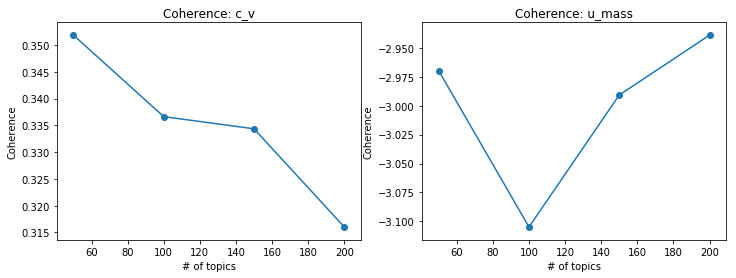

In [12]:
# plot coherence vs # of topics

fig = plt.figure(figsize=(12,4))
fig.add_subplot(121)
plt.plot(ntopics_list, coherence_all_cv)
plt.scatter(ntopics_list, coherence_all_cv)
plt.xlabel('# of topics')
plt.ylabel('Coherence')
plt.title('Coherence: c_v')
fig.add_subplot(122)
plt.plot(ntopics_list, coherence_all_umass)
plt.scatter(ntopics_list, coherence_all_umass)
plt.xlabel('# of topics')
plt.ylabel('Coherence')
plt.title('Coherence: u_mass')
#plt.savefig('coherence.png')
plt.show()

In [8]:
# re-define model using optimal # of topics, and print topics

ntopics = 12
myseed = 0 

lda_model =  gensim.models.LdaMulticore(bow_corpus, num_topics = ntopics, id2word = dictionary, 
                                        random_state=myseed, passes = 10, workers = 2, iterations=300)

for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.054*"busi" + 0.017*"innov" + 0.011*"sale" + 0.011*"research" + 0.009*"opportun" + 0.008*"analyt" + 0.008*"case" + 0.007*"success" + 0.007*"feedback" + 0.007*"excel"


Topic: 1 
Words: 0.021*"algorithm" + 0.013*"method" + 0.013*"regress" + 0.010*"statist" + 0.009*"variabl" + 0.009*"machin" + 0.008*"linear" + 0.008*"imag" + 0.007*"techniqu" + 0.007*"genom"


Topic: 2 
Words: 0.011*"materi" + 0.009*"user" + 0.009*"test" + 0.007*"function" + 0.007*"physic" + 0.007*"equat" + 0.007*"languag" + 0.006*"read" + 0.006*"properti" + 0.005*"chapter"


Topic: 3 
Words: 0.012*"scienc" + 0.010*"life" + 0.009*"human" + 0.008*"chines" + 0.008*"organ" + 0.006*"ethic" + 0.006*"cultur" + 0.006*"social" + 0.006*"examin" + 0.006*"activ"


Topic: 4 
Words: 0.033*"financi" + 0.018*"account" + 0.015*"financ" + 0.014*"invest" + 0.014*"risk" + 0.011*"statement" + 0.010*"valu" + 0.009*"corpor" + 0.009*"asset" + 0.009*"chang"


Topic: 5 
Words: 0.054*"health" + 0.016*"care" + 0.016*"diseas" + 0.0

In [65]:
# interactive visualization of topics with pyLDAvis

pyLDAvis.enable_notebook()
data = pyldagensim.prepare(lda_model, bow_corpus, dictionary,sort_topics=False)

# fix terms to be lemmatized most commonword instead of stemmed word
for row in range(len(data.topic_info.index)):
    if row%10 == 0:
        print(row)
    maxword = dict_stem_maxword[data.topic_info["Term"].iloc[row]]
    data.topic_info["Term"].iloc[row] = maxword
pyLDAvis.save_html(data,'edu-app/static/courseviz.html')
pyLDAvis.display(data)

# data.topic_coordinates

# Uniqueness of topics

Use Jaccard distance to determine how unique the topics are.

In [19]:
jdists = np.zeros((ntopics,ntopics))
for i in range(ntopics):
    topic_terms = lda_model.get_topic_terms(i, topn=30)
    top_terms1 = []
    for x in range(len(topic_terms)):
        top_terms1.append(dictionary[topic_terms[x][0]])
    for j in range(ntopics):
        topic_terms = lda_model.get_topic_terms(j, topn=30)
        top_terms2 = []
        for x in range(len(topic_terms)):
            top_terms2.append(dictionary[topic_terms[x][0]])
        
        jdist = jaccard(top_terms1, top_terms2)
        jdists[i,j] = jdist
    

Median Jaccard distance: 0.9655172413793104


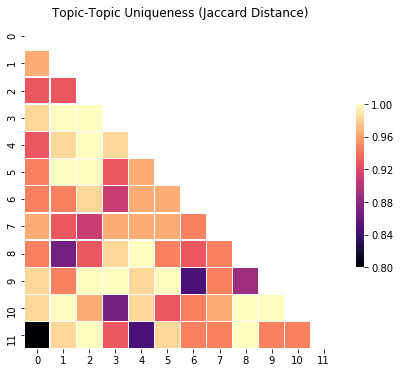

In [20]:
mask = np.zeros_like(jdists, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

uptri_vals = np.triu(jdists)
uptri_vals = uptri_vals[uptri_vals>0]
print('Median Jaccard distance:', np.median(uptri_vals))

plt.figure(figsize=(7,6))
sns.heatmap(jdists, mask=mask, cmap='magma', vmin=np.round(np.min(uptri_vals),2),
            linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Topic-Topic Uniqueness (Jaccard Distance)')
plt.savefig('topic_uniqueness.png')
plt.show()

# Similarity between topic scores

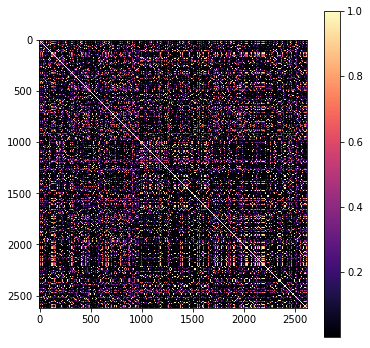

In [18]:
# similarity b/w topic scores 

def doctopics(ind): 
    unseen_document = course_info_all[ind]
    bow_vector = dictionary.doc2bow(preprocess(unseen_document))
    topic_tuples = lda_model.get_document_topics(bow_vector, 0, 0, True)[0]
    topic_scores = np.zeros((1, len(topic_tuples)))
    for i, score in enumerate(topic_tuples):
        topic_scores[0,i] = score[1]
    return topic_scores
    
scoremat = np.zeros((len(course_info_all),ntopics))

for i in range(len(course_info_all)):
    scoremat[i,:] = doctopics(i)
    
savemat('edu-app/scoremat.mat',{'scoremat': scoremat})

thresh = .7
scorecorrs = cos_sim(scoremat)
#scorecorrs[scorecorrs<=thresh] = 0
#scorecorrs[scorecorrs>thresh] = 1

fig = plt.figure(figsize=(6,6))
plt.imshow(scorecorrs, cmap='magma')
plt.colorbar()
plt.show()

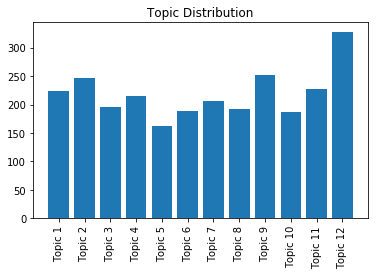

In [12]:
# distribution of best-matching topics

bestmatch = np.argmax(scoremat,axis=1)
freqs = np.histogram(bestmatch, ntopics)[0]
plt.bar(np.arange(ntopics)+1, freqs)
my_x_labels = []
for x in range(ntopics):
    my_x_labels.append('Topic ' + str(x+1))
plt.xticks(np.arange(ntopics)+1,my_x_labels, rotation=90)
plt.gcf().subplots_adjust(bottom=0.20)
plt.title('Topic Distribution')
plt.savefig('topicdist.png')
plt.show()

# Graph theory with networkx

0.6131365423107193
[17.73289968 18.92934188 21.63219876 22.27080743 32.31938823]


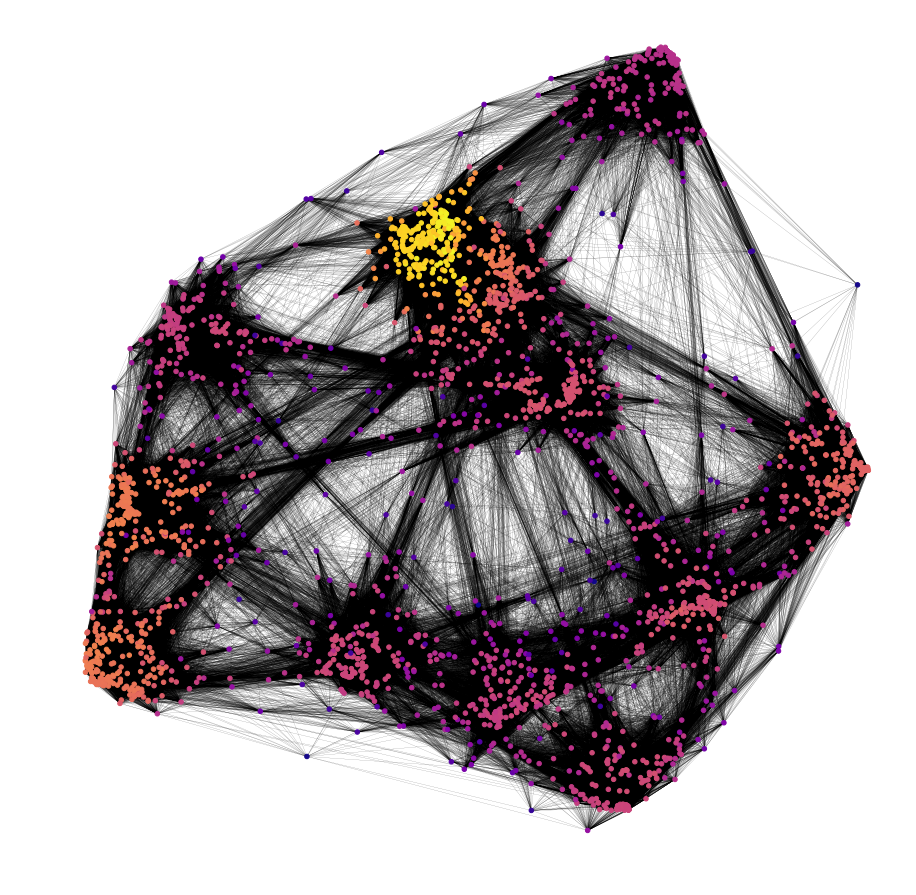

In [17]:
# graph theory with networkx

scorecorrs = cos_sim(scoremat)
scorecorrs_triu = np.triu(scorecorrs)
scorecorrs_triu = scorecorrs_triu[scorecorrs_triu>0]
thresh = np.percentile(scorecorrs_triu,90)
print(thresh)
thresh=.7
scorecorrs[scorecorrs<=thresh] = 0

strength = np.sum(scorecorrs,axis=1)

G = nx.from_numpy_matrix(scorecorrs)
pos = nx.spring_layout(G)
weights = dict(G.degree(weight='weight'))
values = [weights.get(node, 0.25) for node in G.nodes()]

plt.figure(1,figsize=(12,12)) 
nx.draw(G, pos, node_size=20, node_color = values, width=.1, cmap='plasma')
plt.savefig("cousera_lda_network.png", format="PNG")
plt.show(block=False)

file = open('edu-app/networkx_graph.pkl','wb')
pickle.dump(G, file)
file.close()

file = open('edu-app/networkx_pos.pkl', 'wb')
pickle.dump(pos, file)
file.close()

file = open('edu-app/networkx_values.pkl', 'wb')
pickle.dump(values, file)
file.close()

In [18]:
# save node and edge info to file (before weighting based on other numeric info)

list_edges = list(G.edges())

with open('edu-app/static/nodes_orig.csv', mode='w') as fp:
    fwriter = csv.writer(fp, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    fwriter.writerow(['x', 'y', 'strength', 'radius','title'])
    for i in range(len(pos)):
        fwriter.writerow([pos[i][0], pos[i][1], int(values[i]), 2, titles_all[i]])

# write edges.csv
with open('edu-app/static/edges_orig.csv', mode='w') as fp:
    fwriter = csv.writer(fp, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    fwriter.writerow(['x1', 'x2', 'y1', 'y2', 'width', 'color'])
    for i in range(len(list_edges)):
        if list_edges[i][0] != list_edges[i][1]:
            x1 = pos[list_edges[i][0]][0]
            x2 = pos[list_edges[i][1]][0]
            y1 = pos[list_edges[i][0]][1]
            y2 = pos[list_edges[i][1]][1]
            fwriter.writerow([x1, x2, y1, y2, G.edges[list_edges[i][0],list_edges[i][1]]['weight'], '#000000'])

# Validate the LDA model

## How is the LDA model better than Coursera's current recommendation system?

1) The cosine similarity between topic scores for a document (used to train the model) and topic scores from skills tags (not used in model training) is high. Thus, the topics generated from LDA are valid.  

2) However, for a given course, the overlap between the skills tags and the top 10 terms from the most relevant topic is low (max 4/10). Thus, the topics provide more information than the skills tags alone.  

These features are demonstrated with the code below.

In [19]:
def get_course_skills_scores(ind): 
    
    unseen_document = course_info_all[ind]
    bow_vector = dictionary.doc2bow(preprocess(unseen_document))
    topic_tuples = lda_model.get_document_topics(bow_vector, 0, 0, True)[0]
    topic_scores = np.zeros((1, len(topic_tuples)))
    for i, score in enumerate(topic_tuples):
        topic_scores[0,i] = score[1]
        
    course_topic_scores = topic_scores
        
    unseen_document = skills_all[ind]
    bow_vector = dictionary.doc2bow(unseen_document)
    topic_tuples = lda_model.get_document_topics(bow_vector, 0, 0, True)[0]
    topic_scores = np.zeros((1, len(topic_tuples)))
    for i, score in enumerate(topic_tuples):
        topic_scores[0,i] = score[1]
        
    skills_topic_scores = topic_scores
        
    return course_topic_scores, skills_topic_scores

course_skills_sim = []
topterms_in_skills = []

for i in range(len(skills_all)):
    
    # not all courses have skills tags
    if len(skills_all[i])>0:
        course_scores, skills_scores = get_course_skills_scores(i)
        cs_corr = np.corrcoef(course_scores, skills_scores)[0,1]
        cs_sim = cos_sim(course_scores, skills_scores)[0][0]
        course_skills_sim.append(cs_sim)
        
        skills = set(skills_all[i])
        best_topic = np.argmax(course_scores)
        topic_terms = lda_model.get_topic_terms(best_topic, topn=30)
        top_terms = []
        for x in range(len(topic_terms)):
            top_terms.append(dictionary[topic_terms[x][0]])
            
        counter = 0
        for term in top_terms:
            if term in skills:
                counter +=1
        topterms_in_skills.append(counter)
    

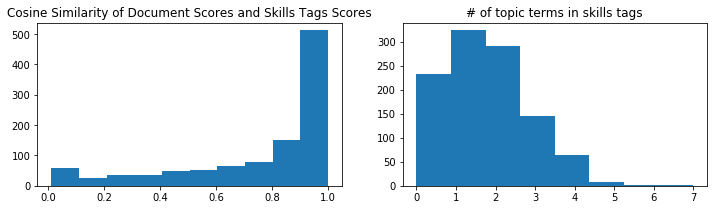

1069 courses had skills tags
Mean similarity between document scores and topic scores: 0.7612275012158641
Median similarity between document scores and topic scores: 0.8888532486384851


In [25]:
# plots to show similarity and overlap

fig = plt.figure(figsize=(12,3))
fig.add_subplot(121); plt.hist(course_skills_sim); 
plt.title('Cosine Similarity of Document Scores and Skills Tags Scores')
fig.add_subplot(122); plt.hist(topterms_in_skills,np.max(topterms_in_skills)+1);
plt.xticks(np.arange(np.max(topterms_in_skills)+1))
plt.title('# of topic terms in skills tags')
plt.savefig('validation1.png')
plt.show()
print(len(course_skills_sim), 'courses had skills tags')
print('Mean similarity between document scores and topic scores:', np.mean(course_skills_sim))
print('Median similarity between document scores and topic scores:',np.median(course_skills_sim))

# topic-topic similarity based on word2vec

In [7]:
# word2vec

# generate and save
# the model has 500 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(processed_info, size=500, min_count=1, sg=1)
w2v_model.save("w2v-model.bin")

# load model
w2v_model = gensim.models.Word2Vec.load("w2v-model.bin")


In [32]:
# median similarity of terms between topics

sim_all = np.zeros((ntopics, ntopics))
for i in range(ntopics):
    topic_terms = lda_model.get_topic_terms(i, topn=30)
    top_terms1 = []
    for x in range(len(topic_terms)):
        top_terms1.append(dictionary[topic_terms[x][0]])
    for j in range(ntopics):
        topic_terms = lda_model.get_topic_terms(j, topn=30)
        top_terms2 = []
        for x in range(len(topic_terms)):
            top_terms2.append(dictionary[topic_terms[x][0]])
        
        sim_topic = np.zeros((30,30))
        for term1 in range(len(top_terms1)):
            for term2 in range(len(top_terms2)):
                sim = w2v_model.similarity(top_terms1[term1], top_terms2[term2]) 
                sim_topic[term1, term2] = sim
        sim_all[i, j] = np.median(sim_topic)


Median term similarity: 0.41106026619672775


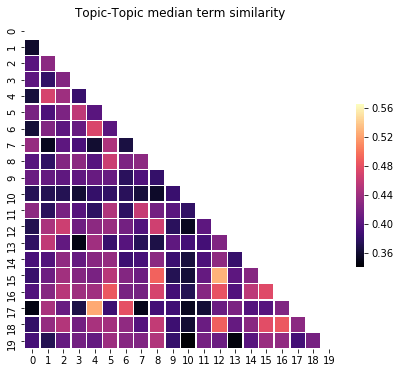

In [39]:
# plot of term similarities between topics 

mask = np.zeros_like(sim_all, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

uptri_vals = np.triu(sim_all)
uptri_vals = uptri_vals[uptri_vals>0]
print('Median term similarity:', np.median(uptri_vals))

plt.figure(figsize=(7,6))
sns.heatmap(sim_all, mask=mask, cmap='magma', vmin=np.round(np.min(uptri_vals),2),
            linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Topic-Topic median term similarity')
plt.show()

# coursera's course recommendations

In [2]:
ncourses = len(titles_all)
coursenet_full = np.zeros((ncourses,ncourses))
for i in range(ncourses):
    mat = loadmat('course_nets/course'+str(good_courses[i])+'.mat')
    coursenet = mat['coursenet']
    coursenet_full[i,:] = coursenet
    inds = np.where(coursenet_full[i,:]==1.0)[0]

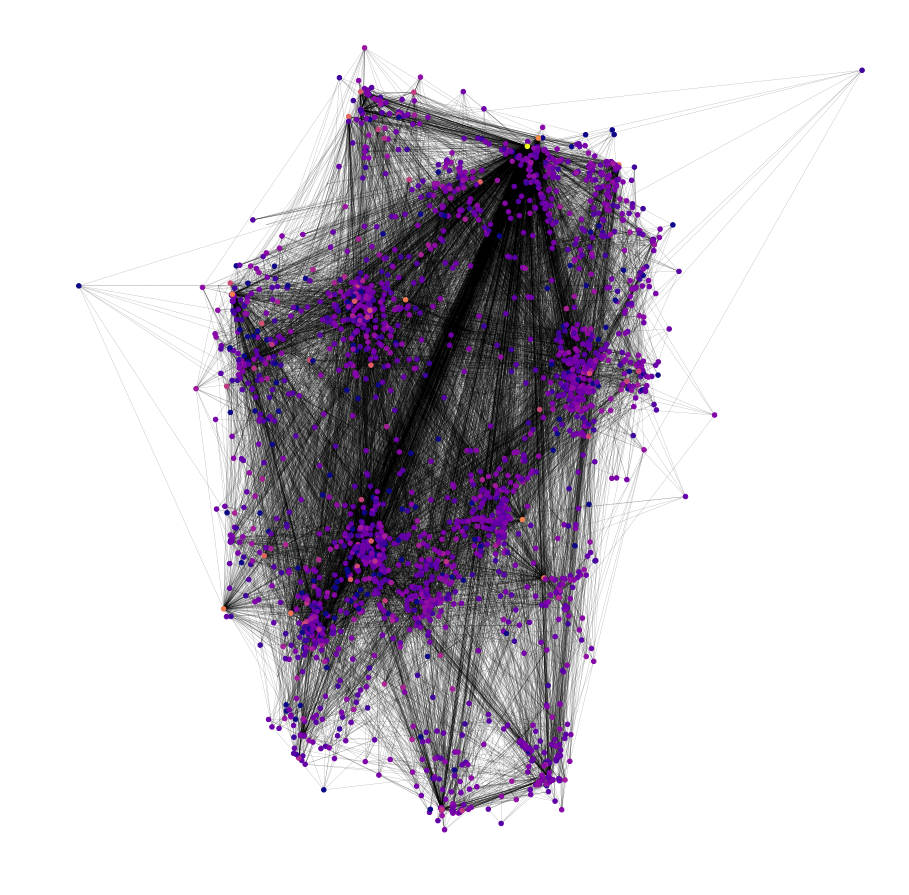

In [68]:
# generate networkx graph and plot

G = nx.from_numpy_matrix(coursenet_full)
weights = dict(G.degree(weight='weight'))
values = [weights.get(node, 0.25) for node in G.nodes()]
pos = nx.spring_layout(G, iterations=10)

values = np.sum(coursenet_full,axis=0)
file = open('edu-app/networkx_pos.pkl','rb')
pos = pickle.load(file)
file.close()

plt.figure(1,figsize=(12,12)) 
nx.draw(G, pos, node_size=20, node_color=np.log10(values), width=.1, cmap='plasma')
#plt.savefig("cousera_lda_network.png", format="PNG")
plt.show(block=False)

122


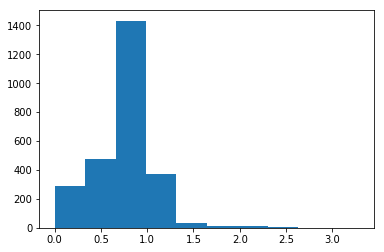

In [69]:
values = np.sum(coursenet_full,axis=0);
print(np.sum(values==0))
plt.hist(np.log10(values+1),10); plt.show()

In [90]:
# topic-topic similarity for courses that are recommended by coursera

coursenet_sim = np.zeros((ncourses,ncourses))
for i in range(ncourses):
    for j in range(ncourses):
        scores1 = scoremat[i,:]
        scores2 = scoremat[j,:]
        if coursenet_full[i,j] == 1:
            coursenet_sim[i,j] = cos_sim(scores1[:,np.newaxis].T,scores2[:,np.newaxis].T)[0][0]
            

In [3]:
# plot course similarity

# plot coursera's course recommendation network
plt.figure(figsize=(12,12))
plt.imshow(coursenet_full, cmap='magma'); plt.show()

# topic-topic similarity for courses that are recommended by coursera
plt.figure(figsize=(12,12))
plt.imshow(coursenet_sim, cmap='magma'); plt.show()

# topic-topic similarity of all courses
plt.figure(figsize=(12,12))
plt.imshow(cos_sim(scoremat), cmap='magma'); plt.show()

NameError: name 'plt' is not defined